DATA LOADING AND SHOWING IMAGE

Loading MNIST dataset...
MNIST dataset loaded.


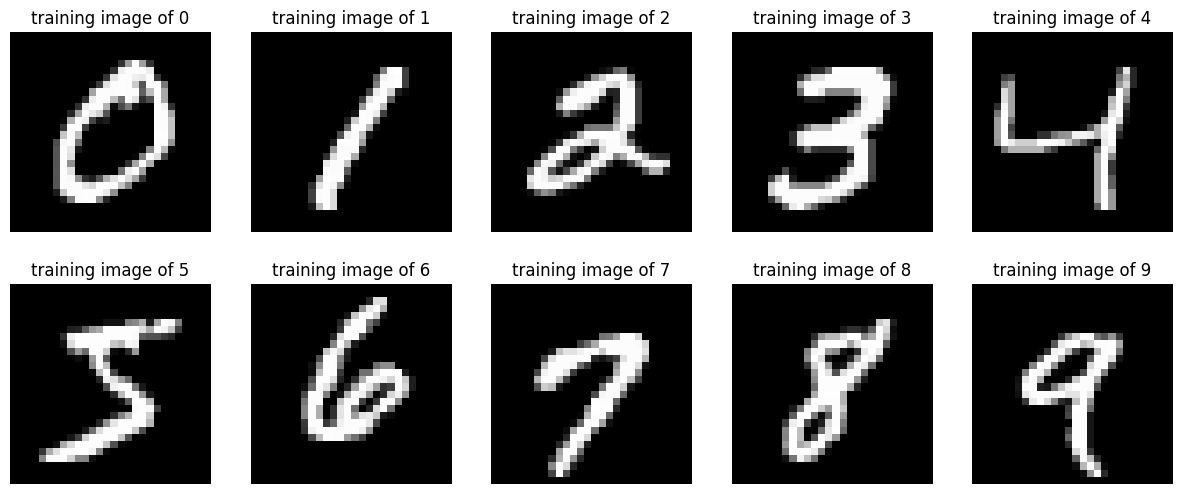

In [41]:
import os
import struct
from array import array
import numpy as np
import matplotlib.pyplot as plt

class MnistDataloader:
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(f'Magic number mismatch, expected 2049, got {magic}')
            labels = np.frombuffer(file.read(), dtype=np.uint8)

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(f'Magic number mismatch, expected 2051, got {magic}')
            images = np.frombuffer(file.read(), dtype=np.uint8).reshape(size, rows, cols)

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)


working_dir = os.getcwd()
training_images_filepath = os.path.join(working_dir, 'train-images.idx3-ubyte')
training_labels_filepath = os.path.join(working_dir, 'train-labels.idx1-ubyte')
test_images_filepath = os.path.join(working_dir, 't10k-images.idx3-ubyte')
test_labels_filepath = os.path.join(working_dir, 't10k-labels.idx1-ubyte')


print('Loading MNIST dataset...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('MNIST dataset loaded.')


def show_images(images, title_texts, cols=5):
    rows = len(images) // cols + (len(images) % cols != 0)
    plt.figure(figsize=(15, 3 * rows))
    for i, (image, title) in enumerate(zip(images, title_texts)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title, fontsize=12)
        plt.axis('off')
    plt.show()


def get_one_image_per_class(images, labels):
    class_dict = {i: None for i in range(10)}  # Dictionary to store one image per class
    filled_classes = set()

    for image, label in zip(images, labels):
        if class_dict[label] is None:
            class_dict[label] = image
            filled_classes.add(label)
        if len(filled_classes) == 10:
            break

    return class_dict

# Get one image per class from the training set
class_images_train = get_one_image_per_class(x_train, y_train)
train_images, train_titles = zip(*[(img, f'training image of {i}') for i, img in class_images_train.items()])


# Show images from training set
show_images(train_images, train_titles, cols=5)




TRAINING AND VALIDATION SETS

In [42]:
from sklearn.model_selection import train_test_split

# Split the training data into 80% training and 20% validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Display the sizes of the resulting datasets
print(f'Training set:   {len(x_train)} images')
print(f'Validation set: {len(x_valid)} images')



Training set:   48000 images
Validation set: 12000 images


In [34]:
from sklearn.model_selection import train_test_split

# Assuming x_train and y_train are your original training data
# Downsample the original training data to 50%
x_train_half, _, y_train_half, _ = train_test_split(x_train, y_train, test_size=0.95, random_state=42)

# Now split the downsampled data into 80% training and 20% validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train_half, y_train_half, test_size=0.2, random_state=42)

# Display the sizes of the resulting datasets
print(f'Training set:   {len(x_train)} images')
print(f'Validation set: {len(x_valid)} images')


Training set:   2400 images
Validation set: 600 images


CNN ARCHITECTURE

Epoch [1/35], Train Loss: 3.0294, Valid Loss: 1.8010
Epoch [2/35], Train Loss: 1.1851, Valid Loss: 1.1836
Epoch [3/35], Train Loss: 0.6014, Valid Loss: 0.5028
Epoch [4/35], Train Loss: 0.3904, Valid Loss: 0.6478
Epoch [5/35], Train Loss: 0.3464, Valid Loss: 0.3832
Epoch [6/35], Train Loss: 0.2440, Valid Loss: 0.3296
Epoch [7/35], Train Loss: 0.1866, Valid Loss: 0.2793
Epoch [8/35], Train Loss: 0.1619, Valid Loss: 0.3038
Epoch [9/35], Train Loss: 0.1286, Valid Loss: 0.2450
Epoch [10/35], Train Loss: 0.1249, Valid Loss: 0.3373
Epoch [11/35], Train Loss: 0.0911, Valid Loss: 0.2513
Epoch [12/35], Train Loss: 0.0715, Valid Loss: 0.2692
Epoch [13/35], Train Loss: 0.0710, Valid Loss: 0.6228
Epoch [14/35], Train Loss: 0.0607, Valid Loss: 0.2346
Epoch [15/35], Train Loss: 0.0255, Valid Loss: 0.2115
Epoch [16/35], Train Loss: 0.0194, Valid Loss: 0.2110
Epoch [17/35], Train Loss: 0.0171, Valid Loss: 0.2104
Epoch [18/35], Train Loss: 0.0122, Valid Loss: 0.3277
Epoch [19/35], Train Loss: 0.0142, Va

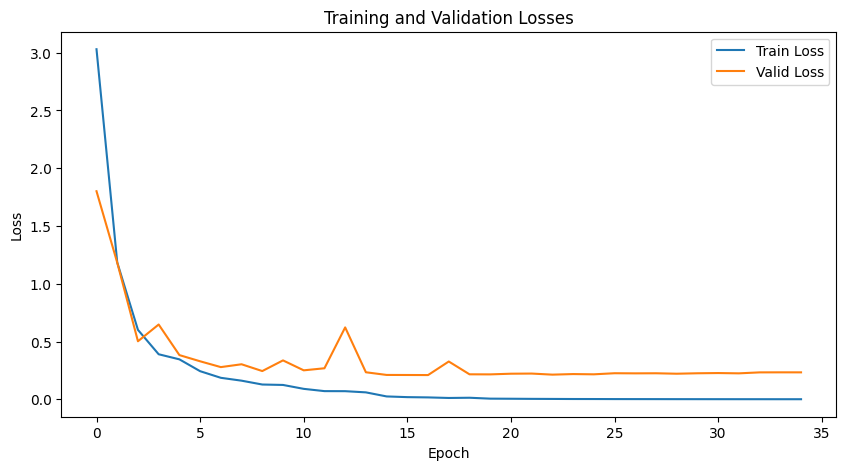

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms

# Set random seed for reproducibility
torch.manual_seed(42)

# Define batch size and other hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 35


# Assuming x_train, x_valid, y_train, y_valid are already defined
# and represent the data split using train_test_split from sklearn

# Convert data to PyTorch Tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_valid_tensor = torch.tensor(x_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Create TensorDataset and DataLoader for training
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create TensorDataset and DataLoader for validation
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)


# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 12 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store losses for plotting
train_losses = []
valid_losses = []

best_valid_loss = float('inf')
best_model_state_dict = None

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))  # Add channel dimension for grayscale images
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data.unsqueeze(1))  # Add channel dimension for grayscale images
            loss = criterion(output, target)
            total_valid_loss += loss.item()
    
    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')
    
    # Save the model with the best validation loss
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state_dict = model.state_dict()

# Load the best model state dict
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print(best_valid_loss)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')


Test Accuracy: 0.9418


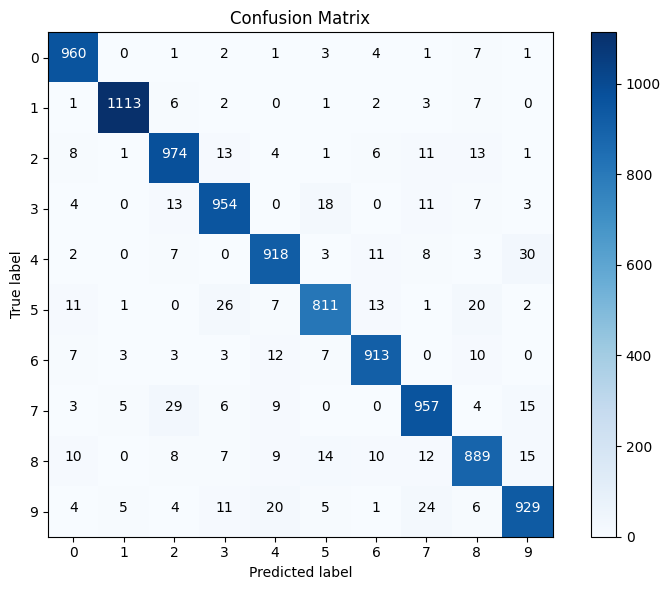

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools  # Import itertools module for iterating over combinations



# Define DataLoader for the test set (using your loaded data)
test_dataset = list(zip(x_test, y_test))  # Create a list of tuples (image, label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize your model (SimpleCNN) and load the best trained weights
model = SimpleCNN()
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set model to evaluation mode

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Iterate over the test set and collect predictions and labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.float()  # Convert input images to float type
        outputs = model(images.unsqueeze(1))  # Unsqueeze to add channel dimension (assuming your model expects a single channel)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


Part2

In [43]:
from skimage.feature import hog
from skimage import color

# Assuming img is your image



def compute_hog_features(images):
    hog_features = []
    for img in images:
        # Compute HoG features for each image
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(fd)
    return hog_features

# Compute HoG features for training and validation sets
x_train_hog = compute_hog_features(x_train)
x_valid_hog = compute_hog_features(x_valid)

# Convert lists to numpy arrays
x_train_hog = np.array(x_train_hog)
x_valid_hog = np.array(x_valid_hog)

print(f'Shape of HoG features - Training set: {x_train_hog.shape}')
print(f'Shape of HoG features - Validation set: {x_valid_hog.shape}')


Shape of HoG features - Training set: (48000, 144)
Shape of HoG features - Validation set: (12000, 144)


Epoch [1/35], Train Loss: 2.3042, Valid Loss: 2.2974
Epoch [2/35], Train Loss: 2.2980, Valid Loss: 2.2925
Epoch [3/35], Train Loss: 2.2923, Valid Loss: 2.2877
Epoch [4/35], Train Loss: 2.2864, Valid Loss: 2.2827
Epoch [5/35], Train Loss: 2.2808, Valid Loss: 2.2777
Epoch [6/35], Train Loss: 2.2749, Valid Loss: 2.2725
Epoch [7/35], Train Loss: 2.2689, Valid Loss: 2.2672
Epoch [8/35], Train Loss: 2.2628, Valid Loss: 2.2617
Epoch [9/35], Train Loss: 2.2566, Valid Loss: 2.2560
Epoch [10/35], Train Loss: 2.2505, Valid Loss: 2.2499
Epoch [11/35], Train Loss: 2.2436, Valid Loss: 2.2436
Epoch [12/35], Train Loss: 2.2366, Valid Loss: 2.2369
Epoch [13/35], Train Loss: 2.2295, Valid Loss: 2.2297
Epoch [14/35], Train Loss: 2.2222, Valid Loss: 2.2222
Epoch [15/35], Train Loss: 2.2138, Valid Loss: 2.2143
Epoch [16/35], Train Loss: 2.2057, Valid Loss: 2.2058
Epoch [17/35], Train Loss: 2.1967, Valid Loss: 2.1969
Epoch [18/35], Train Loss: 2.1876, Valid Loss: 2.1874
Epoch [19/35], Train Loss: 2.1774, Va

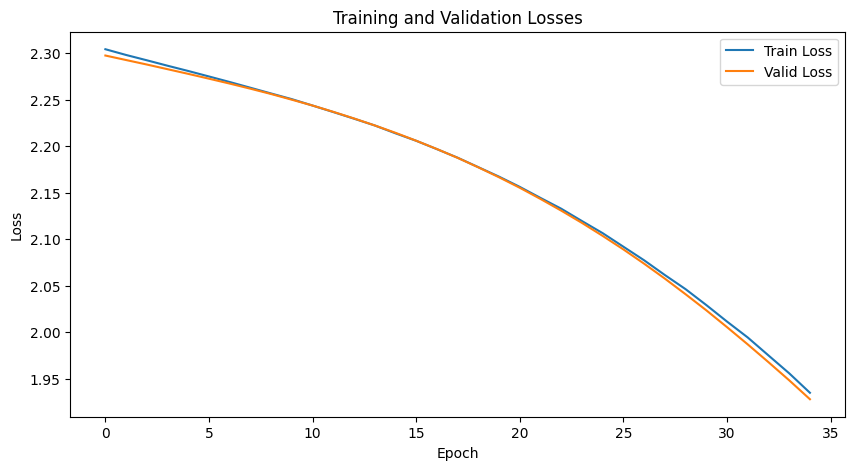

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define batch size and other hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 35

# Assuming x_train_hog and x_valid_hog are already computed
# Convert HoG features to PyTorch Tensors
x_train_tensor = torch.tensor(x_train_hog, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_valid_tensor = torch.tensor(x_valid_hog, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Create TensorDataset and DataLoader for training
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create TensorDataset and DataLoader for validation
valid_dataset = TensorDataset(x_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)



# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.fc1 = nn.Linear(in_features=144, out_features=120)  # 144 is the number of HoG features
        self.fc2 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store losses for plotting
train_losses = []
valid_losses = []

best_valid_loss = float('inf')
best_model_state_dict = None

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)  # Use HoG features directly
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)  # Use HoG features directly
            loss = criterion(output, target)
            total_valid_loss += loss.item()
    
    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')
    
    # Save the model with the best validation loss
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_model_state_dict = model.state_dict()

# Load the best model state dict
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Save the best model
torch.save(model.state_dict(), 'best_model_p2.pth')


In [39]:
# Assuming you have loaded your test images into x_test (list/array of images)

# Compute HoG features for test set
x_test_hog = compute_hog_features(x_test)

# Convert lists to numpy arrays
x_test_hog = np.array(x_test_hog)


Test Accuracy: 0.6295


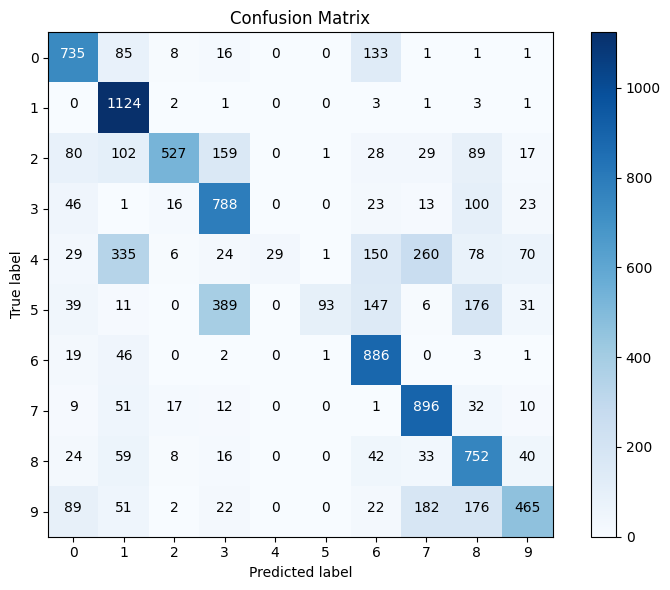

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Assuming x_test_hog and y_test are already computed or assigned
# Convert HoG features to numpy arrays (if not already done)
x_test_hog = np.array(x_test_hog)
y_test = np.array(y_test)

# Define batch size
batch_size = 64

# Create TensorDataset and DataLoader for test set
test_tensor = torch.tensor(x_test_hog, dtype=torch.float32)
test_labels_tensor = torch.tensor(y_test, dtype=torch.long)
test_dataset = TensorDataset(test_tensor, test_labels_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize your model (SimpleCNN) and load the best trained weights
model = SimpleCNN()
model.load_state_dict(torch.load('best_model_p2.pth'))
model.eval()  # Set model to evaluation mode

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Iterate over the test set and collect predictions and labels
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)  # Assuming HoG features are directly passed as input
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy:.4f}')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
